This program trains an artificial neural network to perform magnetic field triangulation based real experimental data.

In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow import keras



# Load the data

In [2]:
# specify the path to the h5 file
path_to_file = 'short_data.h5' # Location of the h5 files

f = h5py.File(path_to_file, 'r')

# convert the h5 contents to a dataframe
data = {group: f[group][()] for group in f}
df = pd.DataFrame(data)

# Create training sets

In [3]:
V0 = df['V0'] # Targets
X = df.iloc[:,1:] # Features

from sklearn.model_selection import train_test_split

# split X and V0 into training and testing sets
X_train, X_test, V0_train, V0_test = train_test_split(X, V0, test_size=0.4, random_state=42)

# split X_test and V0_test into training and testing sets
X_val, X_test, V0_val, V0_test = train_test_split(X_test, V0_test, test_size=0.5, random_state=42)


# Train

In [4]:
model_m = keras.models.Sequential([
    keras.layers.Dense(128,activation='relu'),
    keras.layers.Dense(64,activation='relu'),
    keras.layers.Dense(32,activation='relu'),
    keras.layers.Dense(1)
])
# Compile model
model_m.compile(loss="mae", optimizer = keras.optimizers.Adam(),metrics=["mae"])

In [5]:
# Callbacks
early_stopping_cb = keras.callbacks.EarlyStopping(patience=500, monitor='val_loss',restore_best_weights=True) # Stop training if validation loss is not improving
learning_rate_cb = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=300) # Reduce learning rate is the validation loss is not improving

In [6]:
# Train
history = model_m.fit(X_train, V0_train, epochs=5000, validation_data=(X_val, V0_val), batch_size=16, callbacks=[early_stopping_cb, learning_rate_cb], verbose=True)

Epoch 1/5000
44/44 [==============================] - 2s 5ms/step - loss: 0.0874 - mae: 0.0874 - val_loss: 0.0480 - val_mae: 0.0480 - lr: 0.0010
Epoch 2/5000
44/44 [==============================] - 0s 2ms/step - loss: 0.0386 - mae: 0.0386 - val_loss: 0.0504 - val_mae: 0.0504 - lr: 0.0010
Epoch 3/5000
44/44 [==============================] - 0s 2ms/step - loss: 0.0370 - mae: 0.0370 - val_loss: 0.0450 - val_mae: 0.0450 - lr: 0.0010
Epoch 4/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.0458 - mae: 0.0458 - val_loss: 0.0439 - val_mae: 0.0439 - lr: 0.0010
Epoch 5/5000
44/44 [==============================] - 0s 3ms/step - loss: 0.0341 - mae: 0.0341 - val_loss: 0.0701 - val_mae: 0.0701 - lr: 0.0010
Epoch 6/5000
44/44 [==============================] - 0s 2ms/step - loss: 0.0390 - mae: 0.0390 - val_loss: 0.0725 - val_mae: 0.0725 - lr: 0.0010
Epoch 7/5000
44/44 [==============================] - 0s 4ms/step - loss: 0.0389 - mae: 0.0389 - val_loss: 0.0317 - val_mae: 0.031

Text(0, 0.5, 'mae')

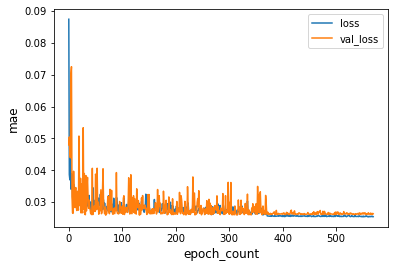

In [7]:
# Plot
h_cnn = history.history
history_df = pd.DataFrame(history.history)
ax= history_df.loc[:, ['loss', 'val_loss']].plot();
#ax.set_ylim(0,2)
ax.set_xlabel(r'epoch_count',fontsize=12)
ax.set_ylabel(r'mae',fontsize=12)

# Test

8/8 [==============================] - 0s 1ms/step


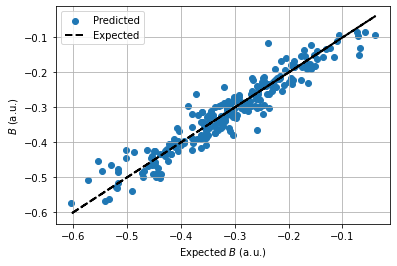

In [8]:
# Apply model to predict the target field
V0_pred = model_m.predict(X_test)

fig, ax = plt.subplots()
ax.scatter(V0_test, V0_pred, label = 'Predicted')
ax.plot(V0_test, V0_test, linewidth=2.0, ls='--', label = 'Expected', color = 'black')
ax.set_ylabel(r'$B$ (a.u.)')
ax.set_xlabel(r'Expected $B$ (a.u.)')
ax.legend(loc=0)
ax.grid()

# Save model

In [9]:
model_m.save('1D_triangulation.h5')